# Bandit Sequence Design

This notebook design the RBS sequences based on bandit algorithms, with the goal to optimize the protein expression level (expressed by translation initiation rate, TIR). The RBS sequence is 20 bps, we focus on -8 ~ -13 bps and fix others as the same as the consensus sequence (i.e. TTTAAGA+NNNNNN+TATACAT). For each base, there are 4 possibilities: A, C, G, T. So totally the feature space is 4^6 = 4096. 

We use [Gaussian Process Upper Confidence Bound (GPUCB)](https://arxiv.org/pdf/0912.3995.pdf) algrithm, with sum of dot product kernel and spectrum kernel of sequences. The algorithm basically includes two parts:

a) First: the Gaussian Process regression model, which predicts the label (GFP/TIR level) and how uncertain we are about our prediction (confidence width); Since the sequences in provided data have the pattern that the core area is different from each other, and other areas are similar. So the kernel for Gaussain Process we are using is the sum of kernels, for core areas we use spectrum kernel with string as input directly, and for other areas we use onehot encoding and dot product kernel for simplicity. 

b) Second: bandit algorithms (Upper Confidence Bound), which recommends sequences to test for next round.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
#from codes.kernels import spectrum_kernel
#from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

The paper [Machine Learning of Designed Translational Control Allows Predictive Pathway Optimization in Escherichia coli](https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398) did similar experiment and based on their data, we recommendation sequences to sample using bandit algorithms. The data contains 113 unrepeated records for 56 unique RBS sequences with TIR label. The label is between 0 ~ 100,000 and skewed (See TIR histogram below). We normalise the label to 0~1 (min-max normalisation). 

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

Path = '../../data/Baseline_data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df['D'] = df['B'].str[7:13]
df.head()

,A,B,C,D
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706,AGCGGG
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613,GACGCG
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313,AGCGCG
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594,AACGAG
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626,GGCGAG


In [3]:
# drop the exact same record (same B and C)

df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 4)

In [4]:
print(df.drop_duplicates(subset = ['B']).shape[0],'unique sequences in total.')

56 unique sequences in total.


Text(0, 0.5, 'Count')

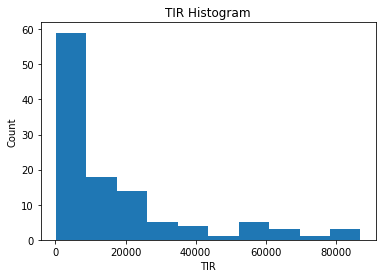

In [5]:
plt.hist(df['C'])
plt.title('TIR Histogram')
plt.xlabel('TIR')
plt.ylabel('Count')
#plt.savefig('../../plots/TIR_histogram.pdf')

In [6]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [7]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data6 = np.asarray(normalize(df)[['D', 'C']])
data6.shape

(113, 2)

In [8]:
# data: num_data * 2, columns: [20-base RBS seq (B), TIR labels (C)]
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

Text(0.5, 1.0, 'Normalised TIR Histogram')

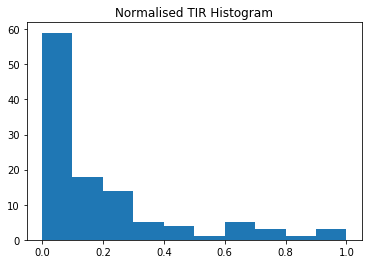

In [9]:
plt.hist(data[:,1])
plt.title('Normalised TIR Histogram')

## Construct feature spaces

We fix the part other the designing 6-base RBS, the 20-based RBS would be: 'TTTAAGA' + 6-base design + 'TATACAT'. The 6-base design has totally 4^6 = 4096 combinations. 

In [10]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combos_6.append(''.join(combo))
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [11]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

## Setting

Since the sequences in provided data have the pattern that the core area is different from each other, and other areas are similar. So the kernel for Gaussain Process we are using is the sum of kernels, for core areas we use spectrum kernel with string as input directly, and for other areas we use onehot encoding and dot product kernel for simplicity. 

In [12]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively
kernel = [Spectrum_Kernel(), Sum_Spectrum_Kernel()]
string_kernel_flag = True

## Recommendations with GPUCB

beta:  1
[1639 1191 2514 1181 1182 1183 3367  151  167   39 3431 2087  158  157
  159 1319 1431  359 2407 1439 1438 1437 1607  473 1383  407 1653 2151
  413  414  415 3175 1631 1629 3479 1630 1497 1658 3943 3485 3486 3487
 1652 1654 1655 2919 1656 1895  871 1659 1660 1661 1662 1663 1657 2521
 1127 1623  103 1495 2535  471  487 2519 1511]


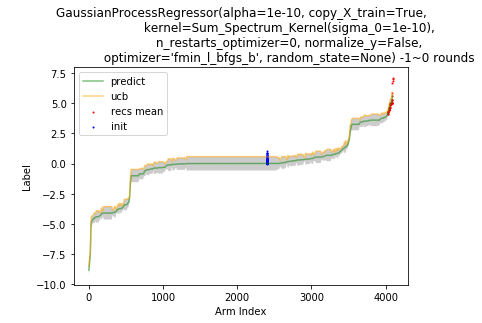

In [13]:
num_rounds = 1 
num_exper = 1
num_rec = 65

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)

agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
          model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

### Convert to RBS seq

In [14]:
bandit20_recs = todesign_data[np.asarray(rec_arms[-60:]),0]

In [15]:
bandit20_recs

array(['TTTAAGAGACGTTTATACAT', 'TTTAAGATGACGTTATACAT',
       'TTTAAGAAACGGTTATACAT', 'TTTAAGAAACCGTTATACAT',
       'TTTAAGAAAACGTTATACAT', 'TTTAAGATGGCGTTATACAT',
       'TTTAAGACAACGTTATACAT', 'TTTAAGAAACGTCTATACAT',
       'TTTAAGAAACGTGTATACAT', 'TTTAAGAAACGTTTATACAT',
       'TTTAAGAGGACGTTATACAT', 'TTTAAGAGGCGGTTATACAT',
       'TTTAAGAAGGCGTTATACAT', 'TTTAAGACGGCGTTATACAT',
       'TTTAAGAGGCGTTTATACAT', 'TTTAAGAGGCGTCTATACAT',
       'TTTAAGAGGCGTGTATACAT', 'TTTAAGAGCGAGTTATACAT',
       'TTTAAGAAGTGCGTATACAT', 'TTTAAGAGGGCGTTATACAT',
       'TTTAAGAAGCGGTTATACAT', 'TTTAAGAGCGTGGTATACAT',
       'TTTAAGACAGCGTTATACAT', 'TTTAAGAAGCGTGTATACAT',
       'TTTAAGAAGCGTCTATACAT', 'TTTAAGAAGCGTTTATACAT',
       'TTTAAGATAGCGTTATACAT', 'TTTAAGAGCGGTTTATACAT',
       'TTTAAGAGCGGTGTATACAT', 'TTTAAGATGCGGTTATACAT',
       'TTTAAGAGCGGTCTATACAT', 'TTTAAGAGGTGCGTATACAT',
       'TTTAAGAGCGTCCTATACAT', 'TTTAAGATTGCGTTATACAT',
       'TTTAAGATGCGTGTATACAT', 'TTTAAGATGCGTCTATACAT',
       'TT

### Detect Repeated Recs

In [16]:
rbs1by1seq = pd.read_csv('../../data/1by1_recs.csv')
rbs1by1 = np.asarray(rbs1by1seq['1by1'].str.upper())

FileNotFoundError: [Errno 2] File b'../../data/1by1_recs.csv' does not exist: b'../../data/1by1_recs.csv'

In [ ]:
random_recs = pd.read_csv('../../data/random_recs.csv')
random = np.asarray(random_recs['uniform'].append(random_recs['ppm']))
random_recs = []
for i in random:
    random_recs.append(pre_design + i + pos_design)

In [ ]:
def common_member(a, b): 
    assert len(a[0]) == len(b[0]) 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

In [ ]:
common_member(rbs1by1, bandit20_recs)

In [ ]:
bandit_drop = common_member(random_recs, bandit20_recs)
bandit_drop

In [ ]:
if type(bandit_drop) is set:
    bandit20_recs = list(bandit20_recs)
    for i in bandit_drop:
        print(i)
        bandit20_recs.remove(i)
        
    bandit20_recs.extend(todesign_data[np.asarray(rec_arms[60: 60 + len(bandit_drop)]),0])
    assert common_member(random_recs, bandit20_recs) == 'no common elements'
    assert len(bandit20_recs) == 60

### Write into csv file

In [ ]:
recs = pd.DataFrame(bandit20_recs, columns = ['bandit'])
recs.index += 1
recs.to_csv('../../data/bandit_recs_0109.csv')

#### Sanity test of idx consistency

In [ ]:
label_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
label_dict = {'0': 'A',
              '1': 'C',
              '2': 'G',
              '3': 'T'}

rbs_seqs = []

for seq in label_seqs:
    rbs_seq = []
    for i in range(int(len(seq))):
        start = i 
        end = start + 1
        s = seq[start:end]
        rbs_seq.append(label_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)

for i in range(len(rec_arms)):
    assert rbs_seqs[i] == todesign_data[rec_arms[i], 0] 
    
print('Recommned index is consistent of the todesign_data index.')

### Plot kernel matrix 

In [ ]:
# use 6-base seuqence for kernel matrix
all_data = np.concatenate((data6, todesign6_data)) # both the observed and todeisign data
all_env = Rewards_env(all_data, embedding)
if len(kernel) == 1:
    kernel_matrix = kernel[0].__call__(all_env.embedded)
else: # string kernels
    kernel_matrix = kernel[0](all_data[:,0])

In [ ]:
kernel_matrix

In [ ]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('spectrum kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

In [ ]:
new_kernel_matrix = kernel_matrix[113:, 113:] # only the todesign feature spaces

## Similarity Test

We expect that for similar arms, the predictor gives similar predictions. The above plot cannot show the similarity relationship between arm. So we design several experiments to show the similarity between arms and corresponding predictions. 

#### The goals are two folds: 
1. Understand how well the predictor works by showing the predictions for arms with similarity information. A good predictor should be able to predict similar labels for similar arms.
2. Explore the similarities of the recommended arms. If the top arms are similar to each other, then they are all from the same cluster, which is not a good way to suggest 60 arms. If they form 5-6 clusters, then this means you will see blocks in the kernel matrix, which is good.

#### The ways to explore similarities:  

A. sort the arm indexes in terms of the 
- A1) predictions (mu) 
- A2) the UCB (mu + sigma)
- A3) the confidence width (sigma)  respectively, then sort the kernel matrix in the same order.

Then we can analyze for similar scores (A1), whether the arms have high similarities. Furthermore, we can analyze the similarities for recommended arms (A2 with top 60). 

B. Using the distance (l2 norm) between every single point to the average one as x-axis, the difference between labels of every point to the averaged label as the y-axis. Then sorted the arm based on the distance of arms, then we expect the higher than the distance of arms, the higher the difference between labels.

C. Using PCA to project the similarity matrix into one/two dimensions. Then use the weight as the x-axis and the corresponding label as the y-axis. Sorted based on the x-axis. Similarly, we expected the neighboring arms have similar labels.

D. Calculate the determinant for the kernel matrix, which reflects the volume of arms. The lower the volume, the higher the similarities. 

### A. sorting by labels

#### A1. sorting by mu

In [ ]:
sorted_idx = np.asarray(sorted(range(len(agent.mu)), key=lambda k: (agent.mu)[k]))
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

In [ ]:
sorted_new_kernel_matrix = new_kernel_matrix[sorted_idx, :][:, sorted_idx]
plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('spectrum sorted kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

In [ ]:
plt.imshow(sorted_new_kernel_matrix[-60:, -60:], cmap = 'hot')
plt.colorbar()
plt.title('spectrum sorted kernel Top 60')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

#### A2. sorting by ucb (mu + sigma)

In [ ]:
sorted_idx = np.asarray(sorted(range(len(agent.mu + agent.sigma)), key=lambda k: (agent.mu + agent.sigma)[k]))
sorted_new_kernel_matrix = new_kernel_matrix[sorted_idx, :][:, sorted_idx]

In [ ]:
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

In [ ]:
#plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.imshow(sorted_new_kernel_matrix[-60:,-60:], cmap = 'hot')
plt.colorbar()
plt.title('Similarity of Bandit Recommendations')
plt.savefig('../../plots/similarity_first_round_recommendation.pdf')

### B. Soring by distance to center one

In [ ]:
distances = []
center = np.mean(kernel_matrix, axis = 0)
for i, row in enumerate(kernel_matrix):
    distance = np.linalg.norm(row - center) ** 2/ len(row)
    distances.append(distance)

In [ ]:
sorted_idx = np.asarray(sorted(range(len(distances)), key=lambda k: (distances)[k]))

sorted_distances = np.asarray(distances)[np.asarray(sorted_idx)]

labels = list(data[:, 1])+ list(agent.mu)
sorted_labels = np.asarray(labels)[np.asarray(sorted_idx)]

In [ ]:
plt.scatter(sorted_distances, abs(sorted_labels - np.mean(labels)), alpha = 0.5)
plt.xlabel('sorted distances')
plt.ylabel('|labels - mean|')

#### A3. sorting by PCA weights

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
embedded = pca.fit_transform(kernel_matrix)
embedded.shape

In [ ]:
plt.scatter(embedded, labels, alpha = 0.5)
plt.xlabel('embedded idx')
plt.ylabel('labels')
plt.title('Sort by PCA')

#### A.4 Determinant

In [ ]:
np.linalg.det(kernel_matrix[-60:, -60:])

### Save into file

In [ ]:
import pickle

with open('sum_spectrum.pickle', 'wb') as handle:
    pickle.dump((agent, kernel_matrix, embedded, all_data), handle, protocol=pickle.HIGHEST_PROTOCOL)